In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')


In [3]:
train_col = df_train.columns.to_list()
test_col = df_test.columns.to_list()
real_col = list(set(train_col) & set(test_col))
real_col.remove('Id')
train_rc=[*real_col,'SalePrice']
df_train = df_train[train_rc]
df_test = df_test[real_col]

In [4]:
def checkna(df):
    colna = pd.DataFrame()
    for i in df.columns.to_list():
        sum = df[i].isnull().sum()
        if(sum>0):
            colna=colna.append({"columns":i,"missing":sum},ignore_index=True)
    return colna

def drop_missing(df,colname):
    try :
        del df[colname]
        return df
    except :
        return df

In [5]:
nadf = checkna(df_train)
for i in range(len(nadf)):
    if nadf.loc[i]['missing'] > 50:
       df_train = drop_missing(df_train,nadf.loc[i]['columns'])
       df_test = drop_missing(df_test,nadf.loc[i]['columns'])

In [6]:
temp_row=df_train[df_train.index == 1379]
temp_row['Electrical']="SBrkr"
df_train[df_train['Electrical'].isnull()]=temp_row

In [7]:
def fill_catno(df,col):
    df[col]=df[col].fillna("None")
    return df

def fill_0(df,col):
    df[col]=df[col].fillna(0)
    return df

def fill_catna(df,col):
    df[col]=df[col].fillna("NA")
    return df

In [8]:
nadf = checkna(df_train)
tnadf = checkna(df_test)

In [9]:
tnalist = set(tnadf['columns'].tolist())
nalist = set(nadf['columns'].tolist())
tnalist.difference_update(nalist)
tnalist=list(tnalist)


In [10]:
tnalist_catna = ['BsmtCond','BsmtFinType1','BsmtExposure','BsmtFinType2','BsmtQual']
tnalist_catno = ['MasVnrType']
tnalist_0 = ['MasVnrArea','TotalBsmtSF','GarageArea','BsmtUnfSF','BsmtFullBath','BsmtFinSF2','BsmtFinSF1','BsmtHalfBath']
rm_list=['YrSold','MoSold','Exterior1st','Utilities','GarageCars','Exterior2nd','KitchenQual','Functional','MSZoning','SaleType']

In [11]:
time_list=['YearRemodAdd','YearBuilt']

In [12]:
df_train=fill_catno(df_train,tnalist_catno)
df_train=fill_catna(df_train,tnalist_catna)
df_train=fill_0(df_train,tnalist_0)

df_test=fill_catno(df_test,tnalist_catno)
df_test=fill_catna(df_test,tnalist_catna)
df_test=fill_0(df_test,tnalist_0)

for i in rm_list:
    df_train=drop_missing(df_train,i)
    df_test=drop_missing(df_test,i)


## normalization


In [13]:
df_train['SalePrice'] = np.log10(df_train['SalePrice'])

## correlation categolog

### merge test/train

In [14]:
df_train['type'] = 'train'
df_test['type'] = 'test'
new_df = pd.concat([df_train,df_test])
new_df_cat = pd.get_dummies(new_df)



### normalization both test/train


In [15]:
def min_max(df,col):
    dmax = df[col].max()
    dmin = df[col].min()
    df[col] = (df[col]-dmin)/(dmax-dmin)
    return df



In [16]:
# for i in time_list:
#     new_df_cat = min_max(new_df_cat,i)


### seperate test/train

In [17]:
df_train = new_df_cat[new_df_cat['type_train']==1]
df_test = new_df_cat[new_df_cat['type_test']==1]

In [18]:
del df_train['type_train']
del df_train['type_test']
del df_test['type_train']
del df_test['type_test']


In [19]:
correlation2 = df_train.corr()
dict_corr2 = correlation2.to_dict()

In [20]:
selected_list = []
for i in dict_corr2:
    if ( correlation2.loc[i,'SalePrice'] > 0.05): 
        selected_list.append(i)

In [21]:
str(selected_list)

"['MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', 'BedroomAbvGr', 'GarageArea', 'ScreenPorch', 'TotRmsAbvGrd', 'HalfBath', 'PoolArea', 'LotArea', '2ndFlrSF', 'GrLivArea', 'OpenPorchSF', '1stFlrSF', 'YearRemodAdd', 'OverallQual', '3SsnPorch', 'BsmtUnfSF', 'BsmtFullBath', 'FullBath', 'YearBuilt', 'TotalBsmtSF', 'SalePrice', 'HouseStyle_2Story', 'Heating_GasA', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'SaleCondition_Partial', 'Electrical_SBrkr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Street_Pave', 'ExterCond_TA', 'BsmtQual_Ex', 'BsmtQual_Gd', 'CentralAir_Y', 'LotConfig_CulDSac', 'BsmtFinType2_Unf', 'ExterQual_Ex', 'ExterQual_Gd', 'RoofStyle_Hip', 'LotShape_IR1', 'LotShap

## train

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [23]:
selected_list.remove('SalePrice')

In [24]:
x_train,x_test,y_train,y_test = train_test_split(df_train[selected_list],df_train['SalePrice'],random_state=1)

In [25]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [26]:
prediction = model.predict(x_test)

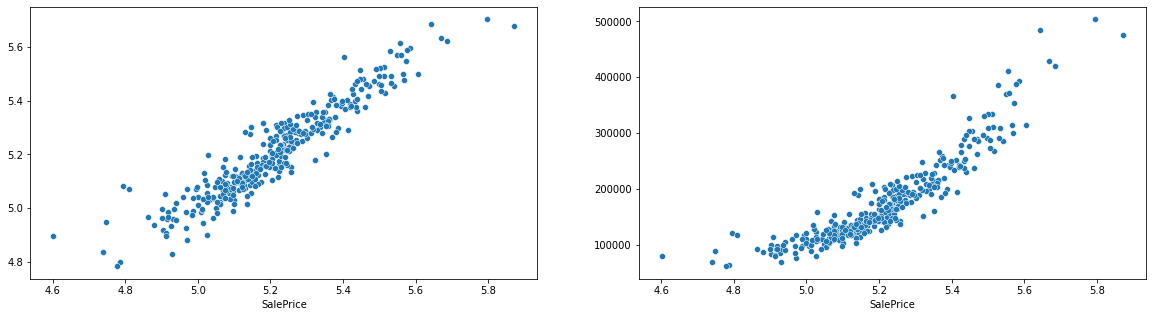

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
ax1=sns.scatterplot(y_test, prediction,ax=ax1)
ax2=sns.scatterplot(y_test, 10**prediction,ax=ax2)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error as mse

In [29]:
mse(y_test,prediction,multioutput='uniform_average',squared=True)

0.003574806511743348

In [30]:
mse(y_test,prediction,multioutput='uniform_average',squared=False)

0.05978968566352685

## real prediction

In [31]:
rx = df_test[selected_list]
rpredict = model.predict(rx)
rpredict = 10**rpredict

In [32]:
import os
def ans_exist():
    count = 1
    while True:
        if(os.path.exists("./ans/submission"+str(count)+".csv")):
            count = count+1
        else:
            return "./ans/submission"+str(count)+".csv"
def save_submission(rPredic):
    df_test_sv = pd.read_csv('./data/test.csv')
    submission = pd.DataFrame()
    submission['Id'] = df_test_sv['Id']
    submission['SalePrice'] = rPredic
    submission.to_csv(ans_exist(), index=False)

In [33]:
save_submission(rpredict)